# Recreating baseline models

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objective**

* Recreating baseline models in the above article

**Files**

* [working-file: petter/baseline-garcia-working.ipynb](/petter/baseline-garcia-working.ipynb)
  * This file contains scrappy code and various bits and pieces
* [previous file - data extraction & eda](/petter/baseline-garcia-1-EDA.ipynb)
  * file contains data extraction and replicated EDA
  * saves data as csv for next file to pick up modelling
* [current file - baseline models](/petter/baseline-garcia-2-model.ipynb)

Outputs to be replicated: 

![garcia-weighted-average-classification-performance](./_images/2024-03-09-15-07-57.png)

## Import csv to dataframe

In [1]:
import pandas as pd

# filepath
garcia_full_scoreNum = '../data/petter/baseline-garcia-full-scoreNum.csv'

# import file
df = pd.read_csv(garcia_full_scoreNum, parse_dates=['date', 'timestamp'])

# print first 5 rows
print(df.head())


            timestamp       date  activity         id  label
0 2003-03-19 00:00:00 2003-03-19         0  control_1      0
1 2003-03-19 00:01:00 2003-03-19         0  control_1      0
2 2003-03-19 00:02:00 2003-03-19         0  control_1      0
3 2003-03-19 00:03:00 2003-03-19         0  control_1      0
4 2003-03-19 00:04:00 2003-03-19       175  control_1      0


## Features

"Each day was characterized by a feature vector which was computed by extracting a set of features on a per day basis from the activity level. The extracted features were the mean activity level, the corresponding standard deviation and the percentage of events with no activity i.e, activity level = 0. The features were normalized between 0 and 1 before the classification." (Garcia-Ceja et al., 2018)

So...

* We need a 'feature vector' by day with:
  * `mean activity level`
  * `standard deviation`
  * `percentage of events with no activity`
* Normalise the features between 0 and 1

Steps to create feature vector: 

1. group by date, id
2. calculate new features by grouped rows
3. join with original df for label, etc.
4. normalise new features
5. drop timestamp, activity 
6. remove duplicates to keep day features

In [11]:
import pandas as pd

# group data by date and id
grouped = df.groupby(['date', 'id'])

# features for each date-id combination - mean, std, and percentage of zeros
features = grouped['activity'].agg(['mean', 'std', lambda x: (x == 0).mean()])
features.columns = ['mean_activity', 'std_activity', 'pct_no_activity']

# reset index to make it a regular dataframe
features = features.reset_index()

# join with the original dataframe to get the labels
df_with_features = df.merge(features, on=['date', 'id'], how='left')

# normalise the features between 0 and 1
df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] = (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min()) / (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].max() - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min())

# drop unnecessary columns
df_processed = df_with_features.drop(['timestamp', 'activity'], axis=1)

# remove duplicate rows
df_processed = df_processed.drop_duplicates()

## Train / Test Split

The new dataframe can be split into `train` and `test` NumPy arrays.

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# separate features and labels
X = df_processed[['mean_activity', 'std_activity', 'pct_no_activity']].values
y = df_processed['label'].values

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# shape of arrays
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(554, 3) (139, 3) (554,) (139,)


## Model

### Evaluate model function

Function to fit model and store metrics. 

In [15]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# cross validation
from sklearn.model_selection import cross_val_score

# metrics
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report


#### Create ZeroRClassifier

In [16]:
from collections import Counter

class ZeroRClassifier:
    def fit(self, X, y):
        self.majority_class = Counter(y).most_common(1)[0][0]
        
    def predict(self, X):
        return [self.majority_class] * len(X)

#### Evaluate model v1

* single run, store various metrics in a dictionary

In [89]:
def evaluate_models_v1(X_train, X_test, y_train, y_test, models):
    """
    Evaluate multiple models using various metrics and return the results.

    Args:
    - X_train (array-like): Training data features.
    - X_test (array-like): Testing data features.
    - y_train (array-like): Training data labels.
    - y_test (array-like): Testing data labels.
    - models (dict): Dictionary of model names and corresponding model objects.

    Returns:
    - results (dict): Dictionary containing evaluation results for each model.
        The keys are the model names and the values are dictionaries containing
        the following metrics:
        - elapsed_time: Time taken to fit the model.
        - accuracy: Accuracy score.
        - precision: Precision score.
        - recall: Recall score.
        - f1: F1 score.
        - specificity: Specificity score.
        - mcc: Matthews correlation coefficient.
        - cm: Confusion matrix.
        - cr: Classification report.
        - roc_auc: ROC AUC score.
    """
    # results dictionary
    results = {}
    
    # fit and time models
    for model_name, model in models:
        start_time = time.time()
        model.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        
        y_pred = model.predict(X_test)
        
        # calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred, pos_label=0)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        
        # calculate roc auc
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except (AttributeError, IndexError):
            y_pred_proba = y_pred
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # save results
        results[model_name] = {
            'elapsed_time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'specificity': specificity,
            'mcc': mcc,
            'cm': cm,
            'cr': cr,
            'roc_auc': roc_auc
        }
        
    return results

#### Evaluate model v2

* cross validation option
* takes whole dataset (X, y)

In [102]:


def evaluate_models_v2(X, y, models, cv=None):
    """
    Evaluate multiple machine learning models on a given dataset, with optional cross-validation.

    Args:
    - X (array-like): The input features.
    - y (array-like): The target variable.
    - models (list): A list of tuples containing the model name and the model object.
    - cv (int, optional): The number of cross-validation folds. If None, perform a single train-test split.

    Returns:
    - results (dict): A dictionary containing the evaluation results for each model.
        - elapsed_time (float): The elapsed time for model training and prediction.
        - accuracy (float): The accuracy score.
        - precision (float): The weighted precision score.
        - recall (float): The weighted recall score.
        - f1 (float): The weighted F1 score.
        - mcc (float or None): The Matthews correlation coefficient. None if not available for cross-validation.
        - cm (array or None): The confusion matrix. None if not available for cross-validation.
        - cr (str or None): The classification report. None if not available for cross-validation.
        - roc_auc (float): The area under the ROC curve score.
    """
    # results dictionary
    results = {}

    # fit and time models
    for model_name, model in models:
        if cv is None:
            start_time = time.time()
            model.fit(X_train, y_train)
            elapsed_time = time.time() - start_time
            y_pred = model.predict(X_test)
        else: # cross-validation scoring
            scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
            scores = {}
            for scorer in scoring:
                scores[scorer] = cross_val_score(model, X, y, cv=cv, scoring=scorer)
            elapsed_time = sum(scores['accuracy'].mean() for scorer in scoring)

        # concat predictions and true labels from all folds
        y_pred = np.concatenate([model.predict(X[test_idx]) for train_idx, test_idx in cv.split(X, y)])
        y_true = np.concatenate([y[test_idx] for train_idx, test_idx in cv.split(X, y)])

        # calculate metrics
        if cv is None:
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            mcc = matthews_corrcoef(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            cr = classification_report(y_test, y_pred)

            try:
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except (AttributeError, IndexError):
                y_pred_proba = y_pred
                roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        else: # cross-validation scoring
            accuracy = scores['accuracy'].mean()
            precision = scores['precision_weighted'].mean()
            recall = scores['recall_weighted'].mean()
            f1 = scores['f1_weighted'].mean()
            mcc = matthews_corrcoef(y_true, y_pred)
            cm = None  # Confusion matrix is not available for cross-validation
            cr = None  # Classification report is not available for cross-validation
            roc_auc = scores['roc_auc'].mean()

        results[model_name] = {
            'elapsed_time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'cm': cm,
            'cr': cr,
            'roc_auc': roc_auc
        }

    return results

#### Evaluate model v2

* Metrics for each class

In [48]:


def evaluate_models_v3(X_train, X_test, y_train, y_test, models):
    # results dictionary
    results = {}

    # fit and time models
    for model_name, model in models:
        start_time = time.time()
        model.fit(X_train, y_train)
        elapsed_time = time.time() - start_time

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True)

        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except (AttributeError, IndexError):
            y_pred_proba = y_pred
            roc_auc = roc_auc_score(y_test, y_pred_proba)

        # calculate metrics for each class
        class_metrics = []
        tn_sum = 0
        fp_sum = 0
        for cls in np.unique(y):
            precision = class_report[str(cls)]['precision']
            recall = class_report[str(cls)]['recall']
            f1 = class_report[str(cls)]['f1-score']
            tn, fp, fn, tp = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]
            specificity = tn / (tn + fp)
            mcc = matthews_corrcoef(y_test, y_pred, sample_weight=None)
            class_metrics.append({
                'class': cls,
                'precision': precision,
                'recall': recall,
                'accuracy': accuracy,
                'specificity': specificity,
                'mcc': mcc,
                'f1': f1
            })
            tn_sum += tn
            fp_sum += fp

        weighted_specificity = tn_sum / (tn_sum + fp_sum)

        weighted_metrics = {
            'precision': class_report['weighted avg']['precision'],
            'recall': class_report['weighted avg']['recall'],
            'accuracy': accuracy,
            'specificity': weighted_specificity,
            'mcc': mcc,
            'f1': class_report['weighted avg']['f1-score']
        }

        results[model_name] = {
            'elapsed_time': elapsed_time,
            'class_metrics': class_metrics,
            'weighted_metrics': weighted_metrics,
            'conf_matrix': conf_matrix,
            'roc_auc': roc_auc
        }


    return results

### Model Selection

In [99]:
models = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVM', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM', SVC(kernel='rbf')),
    ('SVM', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

models_2 = [
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVM', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM', SVC(kernel='rbf')),
    ('SVM', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

### Fitting and evaluating models

#### Version 1 - basic, single run

In [58]:
# version 1 - simplest
results_v1 = evaluate_models_v1(X_train, X_test, y_train, y_test, models)

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

[LightGBM] [Info] Number of positive: 240, number of negative: 314
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433213 -> initscore=-0.268754
[LightGBM] [Info] Start training from score -0.268754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [59]:
# make into a dataframe
df_results = pd.DataFrame.from_dict(results_v1, orient='index')


In [60]:
# results
v1 = df_results[['elapsed_time', 'accuracy', 'precision', 'recall', 'f1', 'specificity','mcc', 'roc_auc']]
print(v1)


                     elapsed_time  accuracy  precision    recall        f1  \
ZeroR                    0.000000  0.633094   0.000000  0.000000  0.000000   
Random Forest            0.117517  0.741007   0.653061  0.627451  0.640000   
Linear SVM               0.000999  0.719424   0.615385  0.627451  0.621359   
Decision Tree            0.002000  0.654676   0.524590  0.627451  0.571429   
Logistic Regression      0.002000  0.719424   0.620000  0.607843  0.613861   
KNN                      0.000999  0.733813   0.620690  0.705882  0.660550   
Naive Bayes              0.000000  0.741007   0.627119  0.725490  0.672727   
Neural Network           0.372727  0.719424   0.625000  0.588235  0.606061   
XGBoost                  0.063003  0.733813   0.634615  0.647059  0.640777   
LightGBM                 0.033004  0.712230   0.600000  0.647059  0.622642   
AdaBoost                 0.082530  0.719424   0.625000  0.588235  0.606061   
QDA                      0.000000  0.776978   0.666667  0.784314

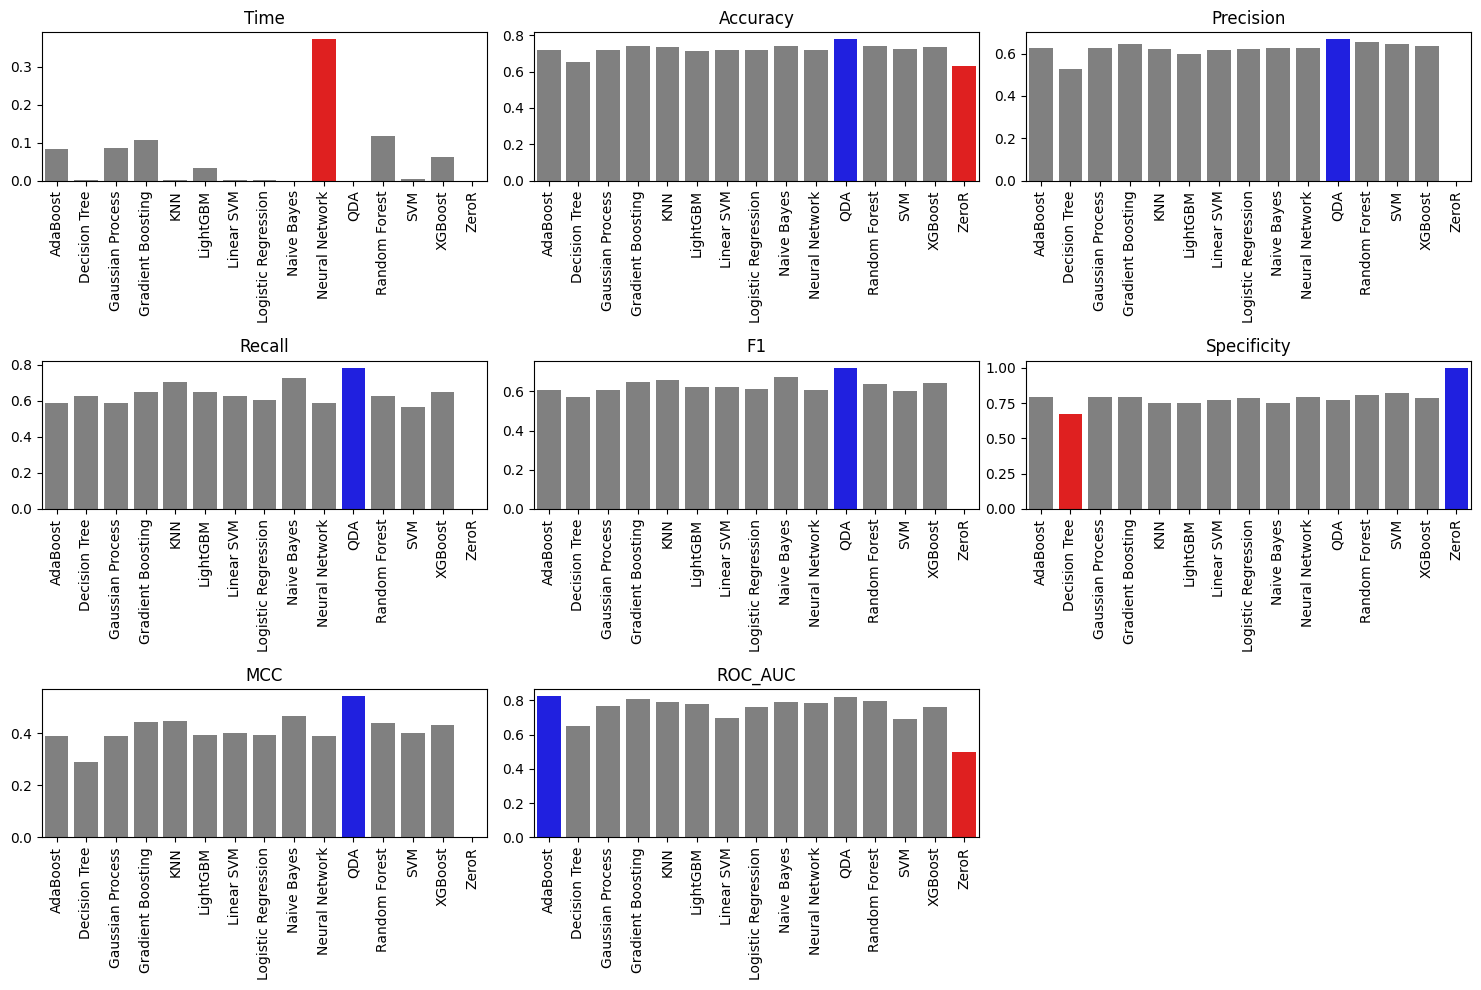

In [76]:

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# List of metrics
metrics = ['elapsed_time', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'roc_auc']
labels = ['Time', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'MCC', 'ROC_AUC']

# plot metrics
for i, metric in enumerate(metrics):
    row = i // 3  # integer division to convert i into a row index
    col = i % 3  # modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = v1.sort_index()  # sort the DataFrame by index
    
    # Find the index of the highest and lowest value for the current metric
    max_index = df_sorted[metric].idxmax()
    min_index = df_sorted[metric].idxmin()
    
    # Create a list of colors for each bar
    if metric == 'elapsed_time':
        colors = ['red' if index == max_index else 'blue' if index == min_index else 'gray' for index in df_sorted.index]
    else:
        colors = ['blue' if index == max_index else 'red' if index == min_index else 'gray' for index in df_sorted.index]
    
    sns.barplot(data=df_sorted, x=df_sorted.index, y=metric, ax=ax, palette=colors, hue=df_sorted.index)  # pass the DataFrame to sns.barplot()
    ax.set_xticks(range(len(df_sorted.index)))  # set the ticks explicitly
    ax.set_xticklabels(df_sorted.index, rotation=90)  # set x-tick labels to the names in the sorted df
    ax.set_title(labels[i])  # modified line
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove unused plots
for i in range(len(metrics), len(axs.flatten())):
    axs.flatten()[i].remove()

plt.tight_layout()
plt.show()


##### Confusion Matrices

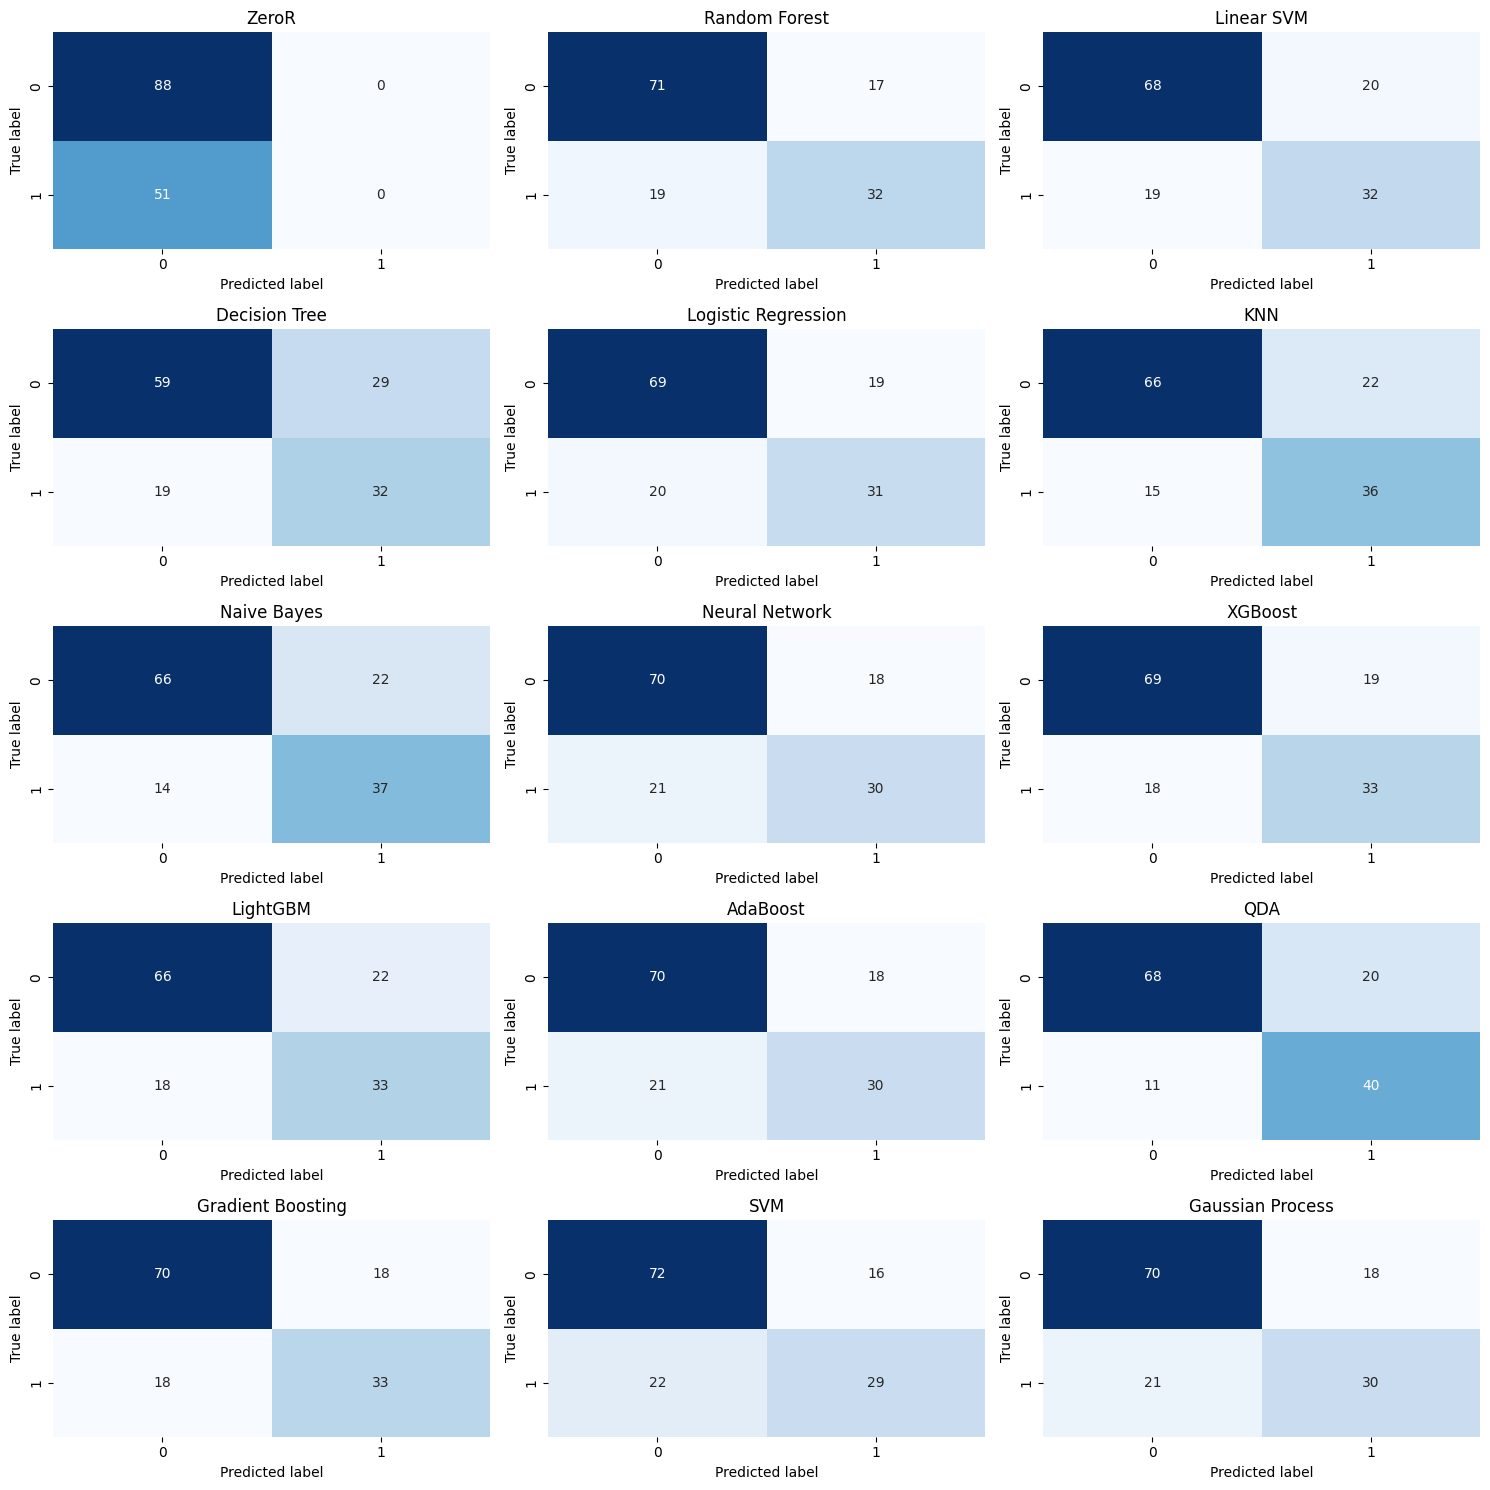

In [86]:
# print confusion matrix
#print(df_results['cm'])

# plot confusion matrix for each model
num_models = len(results_v1)
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, (model_name, model_results) in enumerate(results_v1.items()):
    row = i // num_cols
    col = i % num_cols
    cm = model_results['cm']
    ax = axs[row, col]
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

# Remove unused subplots
for i in range(num_models, num_rows * num_cols):
    axs.flatten()[i].remove()

plt.tight_layout()
plt.show()


#### Version 2 - Cross Validation

In [98]:
# version 2 - with cross-validation
results_v2 = evaluate_models_v2(X, y, models_2, cv=10)

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\U

[LightGBM] [Info] Number of positive: 262, number of negative: 361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420546 -> initscore=-0.320533
[LightGBM] [Info] Start training from score -0.320533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [100]:
# make into a dataframe
df_results_2 = pd.DataFrame.from_dict(results_v2, orient='index')

In [101]:
print(df_results_2)

                     elapsed_time  accuracy  precision    recall        f1  \
Random Forest            3.377743  0.675549   0.674328  0.669814  0.664250   
Linear SVM               3.579710  0.715942   0.719996  0.715942  0.704103   
Decision Tree            3.334369  0.666874   0.662486  0.640932  0.641335   
Logistic Regression      3.565321  0.713064   0.715034  0.713064  0.699603   
KNN                      3.305280  0.661056   0.665684  0.661056  0.652397   
Naive Bayes              3.500621  0.700124   0.709849  0.700124  0.693353   
Neural Network           3.478364  0.695673   0.692590  0.698489  0.682158   
XGBoost                  3.334472  0.666894   0.673594  0.666894  0.661164   
LightGBM                 3.348965  0.669793   0.675202  0.669793  0.665094   
AdaBoost                 3.448861  0.689772   0.695428  0.689772  0.671942   
QDA                      3.558489  0.711698   0.724475  0.711698  0.708537   
Gradient Boosting        3.428157  0.685631   0.695407  0.687081